In [2]:
# !pip install --upgrade seaborn
# !pip install --upgrade scikit-learn
# !pip install --upgrade matplotlib
# !pip install --upgrade pandas
# !pip install --upgrade qiskit
# !pip install qiskit_aqua
# !pip install qiskit_machine_learning
# !pip install pylatexenc

zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip


In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'numpy'

In [1285]:
data_path = "./dataset/"
raw_data = pd.read_csv(data_path + "mnist_train.csv").to_numpy()

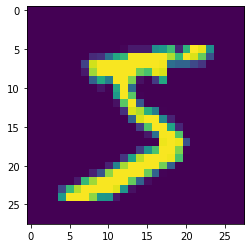

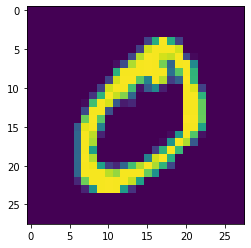

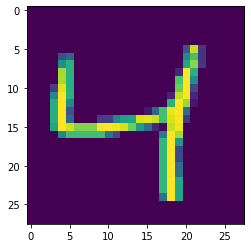

In [1286]:
_image_size = 28
for i in range(3):
    _image = raw_data[i, 1:].reshape((_image_size, _image_size))
    plt.imshow(_image)
    plt.show()

In [1287]:
seed = 12000
np.random.seed(12000)

In [1288]:
# Extracting features and labels from the dataset and truncating the dataset to 10,000 datapoints
number_of_records = 1000
data_features_full_dim = raw_data[:number_of_records, 1:]
data_labels = raw_data[:number_of_records, :1].reshape(number_of_records)

In [1370]:
# Using SVD to reduce dimensions to 10
from sklearn.decomposition import TruncatedSVD

_tsvd = TruncatedSVD(n_components=10, random_state=seed)
_data_features_reduced_to_10 = _tsvd.fit_transform(data_features_full_dim)

# Use t-SNE technique to reduce dimensions to 2
from sklearn.manifold import TSNE

feature_dim = 2
_tsne = TSNE(n_components=feature_dim, random_state=seed)
data_features = _tsne.fit_transform(_data_features_reduced_to_10)

/Users/brison/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/brison/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


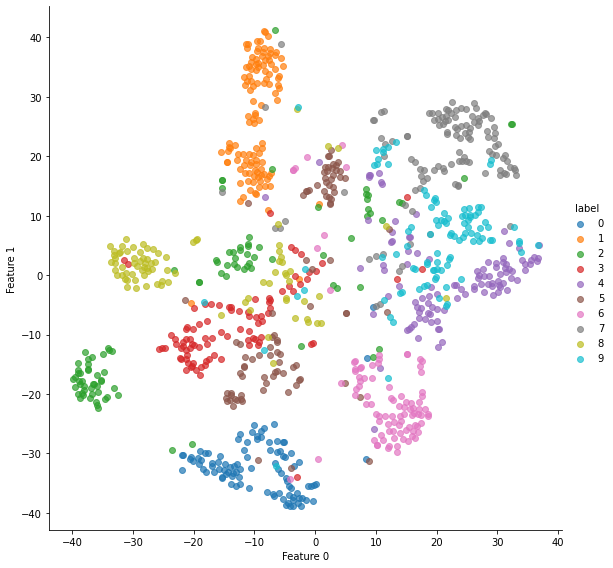

In [1371]:
_x = data_features
_y = data_labels
_lbl_0 = 'Feature 0'; _lbl_1 = 'Feature 1'
_df = pd.DataFrame({_lbl_0:_x[:, 0], _lbl_1:_x[:, 1], 'label':_y})
sns.lmplot(data=_df, x=_lbl_0, y=_lbl_1, fit_reg=False, hue='label', scatter_kws={'alpha':0.7}, height=8)

In [1372]:
def normalize(array):
    positive_array = array - np.min(array)
    normalized_array = (positive_array / np.max(positive_array)) * 2
    return normalized_array

In [1444]:
_train_size = 400
_test_size = 40

_target_data = np.logical_or(data_labels == 0, data_labels == 1)
_target_data_features = data_features[_target_data]
_target_data_labels = data_labels[_target_data]

# preparing train dataset
_train_data_features_for_zeros = _target_data_features[_target_data_labels == 0][:_train_size//2, :]
_train_data_labels_for_zeros = _target_data_labels[_target_data_labels == 0][:_train_size//2]
_train_data_features_for_ones = _target_data_features[_target_data_labels == 1][:_train_size//2, :]
_train_data_labels_for_ones = _target_data_labels[_target_data_labels == 1][:_train_size//2]

_normalized_train_data_features_for_zeros = normalize(_train_data_features_for_zeros)
_normalized_train_data_features_for_ones = normalize(_train_data_features_for_ones)

train_data_features = np.append(_normalized_train_data_features_for_zeros, _normalized_train_data_features_for_ones, 0)
train_data_labels = np.append(_train_data_labels_for_zeros, _train_data_labels_for_ones)
train_data_labels_one_hot = np.array(pd.get_dummies(train_data_labels))

# prepareing test dataset
_test_data_features_for_zeros = _target_data_features[_target_data_labels == 0][-_test_size//2:, :]
_test_data_labels_for_zeros = _target_data_labels[_target_data_labels == 0][-_test_size//2:]
_test_data_features_for_ones = _target_data_features[_target_data_labels == 1][-_test_size//2:, :]
_test_data_labels_for_ones = _target_data_labels[_target_data_labels == 1][-_test_size//2:]

_normalized_test_data_features_for_zeros = normalize(_test_data_features_for_zeros)
_normalized_test_data_features_for_ones = normalize(_test_data_features_for_ones)

test_data_features = np.append(_normalized_test_data_features_for_zeros, _normalized_test_data_features_for_ones, 0)
test_data_labels = np.append(_test_data_labels_for_zeros, _test_data_labels_for_ones)
test_data_labels_one_hot = np.array(pd.get_dummies(test_data_labels))

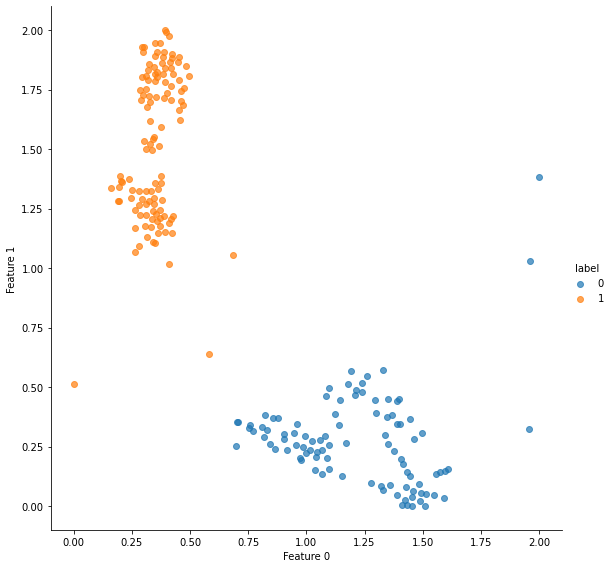

In [1453]:
_x = train_data_features
_y = train_data_labels
_lbl_0 = 'Feature 0'; _lbl_1 = 'Feature 1'    
_df = pd.DataFrame({_lbl_0:_x[:, 0], _lbl_1:_x[:, 1], 'label':_y})
sns.lmplot(data=_df, x=_lbl_0, y=_lbl_1, fit_reg=False, hue='label', scatter_kws={'alpha':0.7}, height=8)

In [1446]:
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap

feature_map = ZFeatureMap(feature_dimension=feature_dim, reps=1)

In [1447]:
from qiskit.circuit.library import RealAmplitudes, EfficientSU2

ansatz = RealAmplitudes(num_qubits=feature_dim, reps=1)

In [1448]:
from qiskit.algorithms.optimizers import ADAM, COBYLA

optimizer = COBYLA(maxiter=100, tol=0.01)

In [1449]:
from IPython.display import clear_output

objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance

# initilizing backend
_backend = BasicAer.get_backend('qasm_simulator')
_backend_options = {"method": "statevector"}

# creating a quantum instance
quantum_instance = QuantumInstance(
    _backend, 
    shots=1024, 
    seed_simulator=seed, 
    seed_transpiler=seed, 
    backend_options=_backend_options)

In [1450]:
from qiskit_machine_learning.algorithms.classifiers import VQC

# initilizing VQC object
vqc = VQC(
    optimizer=optimizer, 
    feature_map=feature_map, 
    ansatz=ansatz, 
    quantum_instance=quantum_instance,
    callback=callback_graph)

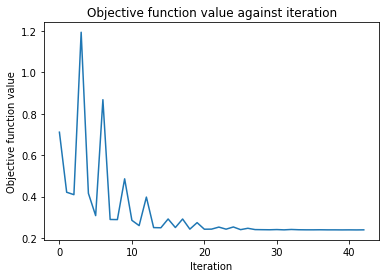

In [1451]:
objective_func_vals = []
vqc.fit(train_data_features, train_data_labels_one_hot)

In [1452]:
accuracy = vqc.score(test_data_features, test_data_labels_one_hot)
print("Model accuracy:", round(accuracy, 2))

Model accuracy: 0.95
